In [2]:
import pandas as pd
import sqlite3
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import numpy as np

In [3]:
# Load the trained models
log_model = joblib.load("../Resources/logistic_regression_model.pkl")
tree_model = joblib.load("../Resources/decision_tree_model.pkl")
rf_model = joblib.load("../Resources/random_forest_model.pkl")

print("Models loaded successfully")

Models loaded successfully


In [4]:
# Connect to SQLite database
sqlite_db_path = "../student_performance.db"
conn = sqlite3.connect(sqlite_db_path)
df_mat = pd.read_sql("SELECT * FROM student_mat", conn)
df_por = pd.read_sql("SELECT * FROM student_por", conn)
df = pd.concat([df_mat, df_por], ignore_index=True)
conn.close()

# Display first few rows
print("Sample Data:")
display(df.head())

Sample Data:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [5]:
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [6]:
df['sudden_grade_drop'] = df['G1'] - df['G2']
df['attendance_engagement'] = df['absences'] / (df['G1'] + df['G2'] + df['G3'] + 1)
df['low_engagement_flag'] = (df['attendance_engagement'] > df['attendance_engagement'].quantile(0.75)).astype(int)

X_analysis = df.drop(columns=['G3'])

In [7]:
# Predicting
df['Predicted_Performance_Log'] = log_model.predict(X_analysis)
df['Predicted_Performance_Tree'] = tree_model.predict(X_analysis)
df['Predicted_Performance_RF'] = rf_model.predict(X_analysis)

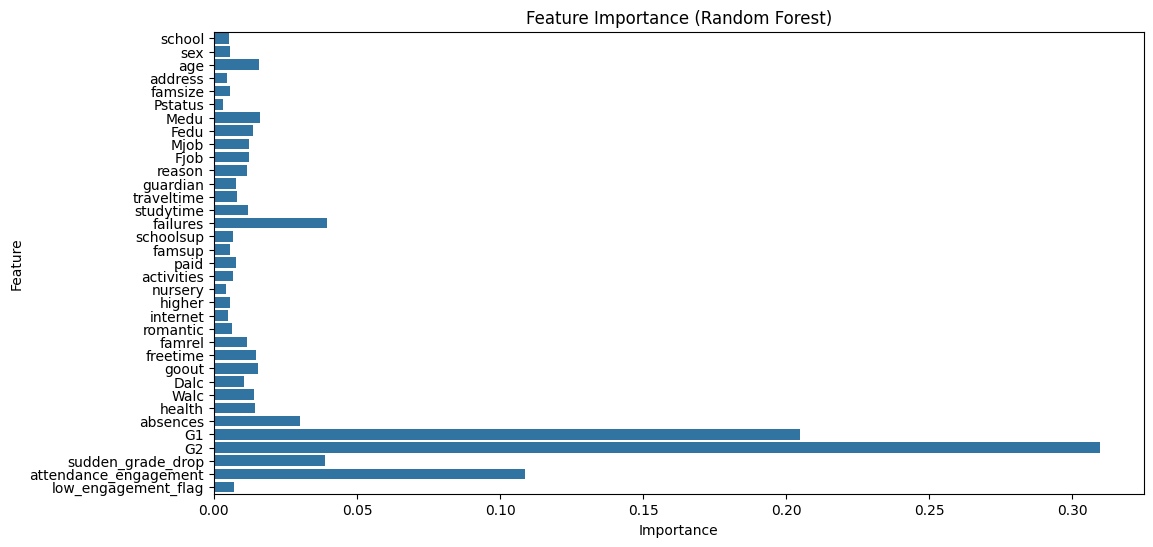

In [8]:
# Feature importance analysis

feature_importance = rf_model.feature_importances_
feature_names = X_analysis.columns

plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance, y=feature_names)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

/var/folders/3_/rmrvnzms2mz1nrycz1_y7_j80000gn/T/ipykernel_97929/1846239627.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette=colors, edgecolor='black')
/var/folders/3_/rmrvnzms2mz1nrycz1_y7_j80000gn/T/ipykernel_97929/1846239627.py:13: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x=top_importances, y=top_features, palette=colors, edgecolor='black')


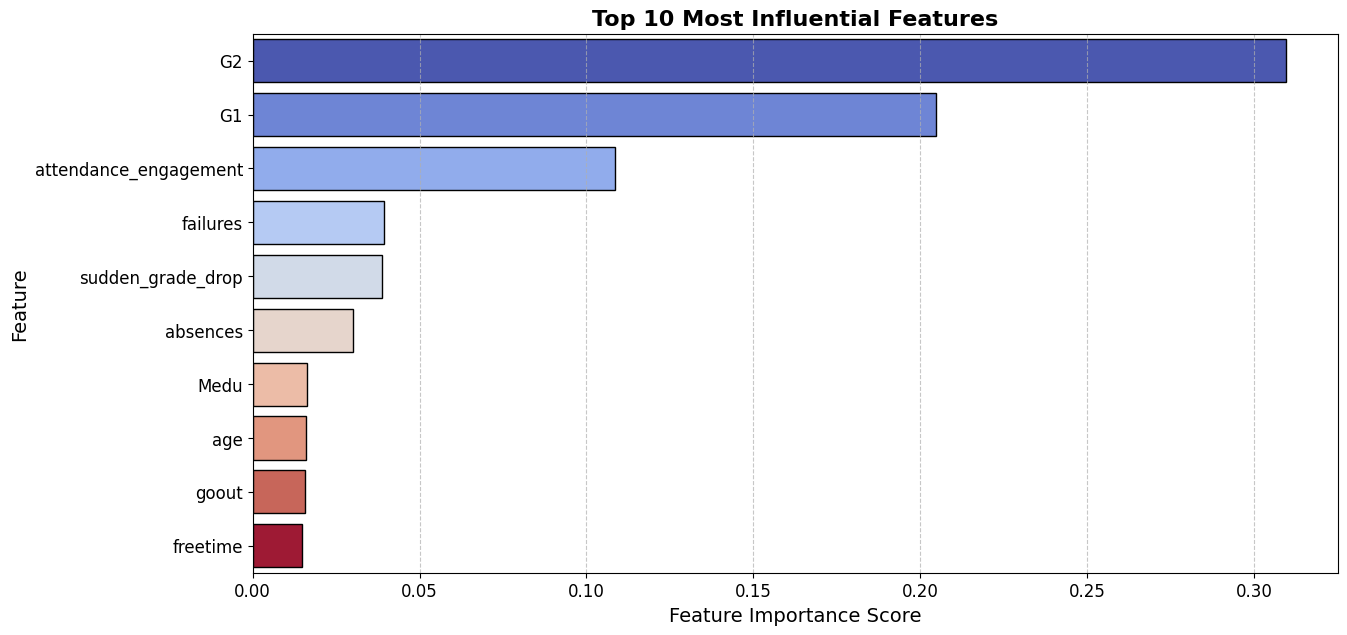

In [9]:
# Get feature importance values
feature_importance = rf_model.feature_importances_
feature_names = X_analysis.columns

# Sort feature importance in descending order and select top 10
sorted_idx = feature_importance.argsort()[::-1][:10]
top_features = [feature_names[i] for i in sorted_idx]
top_importances = feature_importance[sorted_idx]

# Plot the top 10 important features
plt.figure(figsize=(14, 7))
colors = cm.coolwarm(np.linspace(0, 1, len(top_features)))
sns.barplot(x=top_importances, y=top_features, palette=colors, edgecolor='black')
plt.title("Top 10 Most Influential Features", fontsize=16, fontweight='bold')
plt.xlabel("Feature Importance Score", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

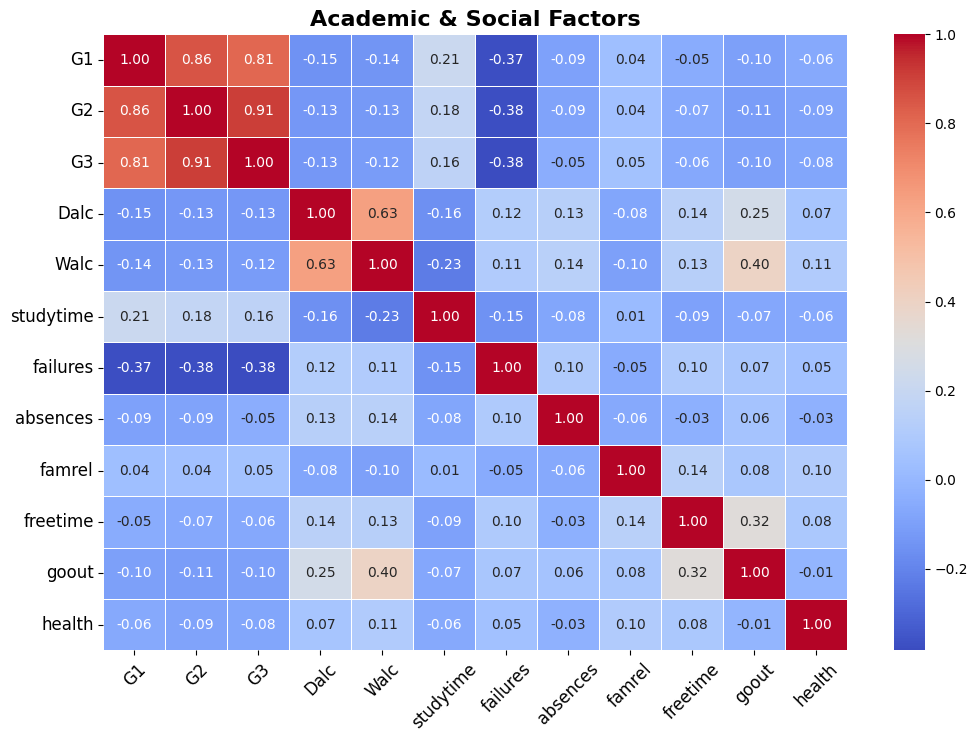

In [10]:
# correlation heatmap to analyze the relationships between acedemic and social factors
correlation_features = ['G1', 'G2', 'G3', 'Dalc', 'Walc', 'studytime', 'failures', 'absences', 'famrel', 'freetime', 'goout', 'health']
correlation_data = df[correlation_features]

# Compute correlation matrix
correlation_matrix = correlation_data.corr()

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Academic & Social Factors", fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()


/var/folders/3_/rmrvnzms2mz1nrycz1_y7_j80000gn/T/ipykernel_97929/3900876212.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['goout'], y=df['G3'], palette='coolwarm')


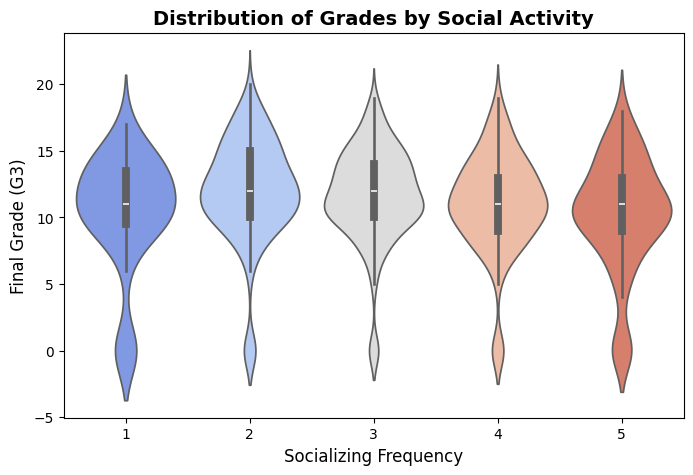

In [11]:
df_mat = pd.read_csv("../Resources/stu_mat.csv")
df_por = pd.read_csv("../Resources/stu_por.csv")
df = pd.concat([df_mat, df_por], ignore_index=True)

# Group socializing frequency into fewer bins for readability
df['G3'] = df['G3'].astype(int)  # Convert to integer for accuracy

# Violin plot with G3 from the original dataset
plt.figure(figsize=(8, 5))
sns.violinplot(x=df['goout'], y=df['G3'], palette='coolwarm')
plt.xlabel("Socializing Frequency", fontsize=12)
plt.ylabel("Final Grade (G3)", fontsize=12)
plt.title("Distribution of Grades by Social Activity", fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()
